## Usefuls sources of informations:


In [1]:
import torch
import math
import time
import datetime
import random

from torch import Tensor
torch.set_grad_enabled(False)

In [2]:
# The father of all Modules
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
        
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

## Activation

À part ReLU et Tanh c'est pas précisé dans l'énoncé - là c'est juste pour le flex

In [3]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.clamp(0)

    def backward(self, gradwrtoutput):
        input = self.t
        sign = input.sign().clamp(0)
        return sign * gradwrtoutput
        
    def param(self):
        return []

In [4]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        
        out = []
        for x in input :
            e = math.exp(-2 * x)
            val = (1 - e) / (1 + e)
            out.append(val)
        return torch.FloatTensor(out)

    def backward(self, gradwrtoutput):
        z = self.t
        e = torch.exp(-2 * z)
        d_tanh = 4 * e / (1 + e)**2
        return d_tanh * gradwrtoutput
        
    def param(self):
        return []

In [5]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.mul(-1).exp().add(1).pow(-1)

    def backward(self, gradwrtoutput):
        sig = self.t.mul(-1).exp().add(1).pow(-1)
        return sig.mul(-1).add(1).mul(sig)
        
    def param(self):
        return []

## Layers

In [6]:
class Linear(Module):
    def __init__(self, input_size, output_size, mean=0, std=1):
        super().__init__()
        self.W = torch.empty(output_size, input_size).normal_(mean, std)
        self.b = torch.empty(output_size).normal_(mean, std)
        self.dW = torch.zeros(output_size, input_size)
        self.db = torch.zeros(output_size)
    def forward(self, input):
        self.t = input
        return self.W.mv(input).add(self.b)

    def backward(self, gradwrtoutput):
        self.dW.add_(gradwrtoutput.view(1, -1).t().mm(self.t.view(1, -1)))
        self.db.add_(gradwrtoutput)
        #print(gradwrtoutput.shape, self.W.shape)
        return self.W.t().mv(gradwrtoutput)
        
        
    def param(self):
        return [(self.W, self.dW), (self.b, self.db)]

In [7]:
class Dropout(Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        for i in range(input.shape[0]):
            if random.random() < self.p : 
                input[i] = 0 
        return input
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput
        
        
    def param(self):
        return []

In [8]:
l = Dropout(0.5)
t = torch.empty(10).fill_(1)
l.forward(t)

tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])

## Sequential

Lui en input il prend une liste de modules et son fwd c'est de feed le fwd de chaque layer dans l'autre

In [9]:
class Sequential(Module):
    def __init__(self, module_list):
        super().__init__()
        self.modules = module_list
        
    def forward(self, input):
        x = input
        for module in self.modules :
            x = module.forward(x)
        return x 

    def backward(self, gradwrtoutput):
        x = gradwrtoutput
        for module in reversed(self.modules) :
            x = module.backward(x)
        return x
        
    def param(self):
        params = []
        for module in self.modules:
            for par in module.param():
                params.append(par)
        return params

## Loss

Seule lossMSE est demandé

In [10]:
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).pow(2).mean()
    
    # J'ai pas mis les arguments dans backward car je pars du principe que la MSE est la dernière fonction utilisée
    def backward(self):
        return 2 * (self.pred - self.target)
    
    def param(self):
        return []

In [11]:
class LossMAE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).abs().mean()

    def backward(self):
        error = self.pred - self.target
        return error.sign()
        
    def param(self):
        return []

In [12]:
# Binary cross entropy loss
# Note: We need to use sigmoid function before using BCE otherwise it makes no sense
class LossBCE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return ((target * pred.log()) + ((1 - target) * (1 - pred).log())).mean()

    def backward(self):
        return ((-target/pred) + ((1 - target)/(1 - pred))).mean()
        
    def param(self):
        return []

## Optimizer

Pas demandé mais fancy

In [13]:
class SGD():
    def __init__(self, params, lr, seq = True):
        self.params = params
        self.lr = lr
        self.seq = seq
    def step(self): 
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                param.sub_(grad, alpha=self.lr)
    
    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        for idx, i in enumerate(self.params):
            print(idx, i)

In [14]:
class Adam():
    def __init__(self, params, lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.params = params
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        # Adam inner values 
        self.t = 0
        self.adam_values = []
        for t in self.params:
            t0, t1 = t
            self.adam_values.append((torch.zeros_like(t0), torch.zeros_like(t1)))

    def step(self):
        self.t += 1 
        for idx_module, module in enumerate(self.params):
            param, grad = module
            if (param is not None) and (grad is not None):
                #Update Vd and Sd, for each tuple we keep vd and sd 
                vd, sd = self.adam_values[idx_module]

                vd.mul_(self.beta_1).add_(grad.mul(1 - self.beta_1))
                sd.mul_(self.beta_2).add_(grad.pow(2).mul(1 - self.beta_2))

                # Compute corrected Values
                vd_corr = vd.mul(torch.tensor([[self.beta_1]]).pow(self.t).mul(-1).add(1).pow(-1)) 
                sd_corr = sd.mul(torch.tensor([[self.beta_2]]).pow(self.t).mul(-1).add(1).pow(-1)) 

                # Update the parameter 
                v =sd_corr.sqrt().add(self.epsilon).pow(-1).mul(vd_corr)
                
                param.sub_(v.reshape(param.shape), alpha=self.lr)

    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        print(self.t)
        print("PARAMS : ")
        for i in self.params:
            print(i)
        print(("ADAM [Vd, Sd] : "))
        for i in self.adam_values:
            print(i)

## Data generation

In [15]:
def generate_disc_dataset(nb, seed=0):
    torch.manual_seed(seed)
    input = torch.empty(nb, 2).uniform_(0, 1)
    
    distance = torch.norm((input - torch.Tensor([[0.5, 0.5]])), 2, 1, True)
    target = distance.mul(math.sqrt(2*math.pi)).sub(1).sign().sub(1).div(-2).long()  
    return input, target

In [16]:
def one_hot_encoder(target):
    return torch.empty(target.size(0), 2).zero_().scatter_(1, target.view(-1, 1), 1)

In [17]:
def split_dataset(input, target, train_perc):
    train_part = math.floor(target.size()[0] * train_perc)
    test_part = target.size()[0] - train_part
    
    train_input = input.narrow(0, 0, train_part)
    test_input = input.narrow(0, train_part, test_part)
    
    train_target = target.narrow(0, 0, train_part)
    test_target = target.narrow(0, train_part, test_part)
    
    return train_input, train_target, test_input, test_target

In [18]:
def normalize_data(train, test):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    test = (test - mean) / std
    return train, test

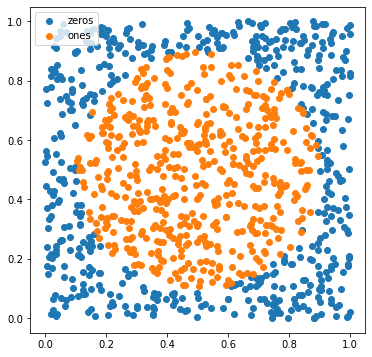

In [19]:
import matplotlib.pyplot as plt 

input, target = generate_disc_dataset(1000)

def plot_from_input(input, target):
    zeros = input[(target == 0).nonzero()[:,0]]
    ones = input[target.nonzero()[:,0]]
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.savefig('generated_data.png')
    plt.show()

plot_from_input(input, target)

## Train / Test

In [81]:
def train_SGD(model, train_input, train_target, learning_rate=0.0001, nb_epochs=500, print_ = False):
    print(f"Training the model on {nb_epochs} epochs with SGD optimizer and learning rate {learning_rate}")
    criterion = LossMSE()
    optimizer = SGD(model.param(), learning_rate)
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
            
        if print_ :
            print(f"epoch {epoch}, Loss {acc_loss}")
    return model

def train_adam(model, train_input, train_target, learning_rate=0.05, nb_epochs=500, print_ = False):
    print(f"Training the model on {nb_epochs} epochs with Adam optimizer and learning rate {learning_rate}")
    criterion = LossMSE()
    optimizer = Adam(model.param(), learning_rate)
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
        
        if print_:
            print(f"epoch {epoch}, Loss {acc_loss}")
    return model

In [95]:
# Compute the accuracy and plot the results for two outputs 
def accuracy_and_plot_two_output(model, test_input, test_label):
    nb_correct = 0
    nb_total = test_input.shape[0]
    zeros = []
    ones = []
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        if prediction.argmax() == 0 :
            zeros.append(input)
        else :
            ones.append(input)
        
        nb_correct += prediction.argmax() == target
    zeros = torch.stack(zeros)
    ones = torch.stack(ones)
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.show()
    accuracy = 100 * nb_correct.item() / nb_total
    error_rate = 100 - accuracy
    print(f'Accuracy is : {accuracy}%')
    print(f'Error rate : {error_rate}%')
    
    return accuracy, error_rate

def accuracy_two_output(model, test_input, test_label, print_ = True):
    nb_correct = 0
    nb_total = test_input.shape[0]
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        
        nb_correct += prediction.argmax() == target
    accuracy = 100 * nb_correct.item() / nb_total
    error_rate = 100 - accuracy
    if print_ :
        print(f'Accuracy is : {accuracy}%')
        print(f'Error rate : {error_rate}%')
    
    return accuracy, error_rate


# Compute the accuracy for 1 output 
def accuracy_and_plot_one_output(model, test_input, test_label):
    nb_correct = 0
    nb_total = test_input.shape[0]
    zeros = []
    ones = []
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        if prediction.round() == 0 :
            zeros.append(input)
        else :
            ones.append(input)
        
        nb_correct += prediction.round() == target
    zeros = torch.stack(zeros)
    ones = torch.stack(ones)
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.show()
    accuracy = 100 * nb_correct.item() / nb_total
    error_rate = 100 - accuracy
    print(f'Accuracy is : {accuracy}%')
    print(f'Error rate : {error_rate}%')

def accuracy_one_output(model, test_input, test_label, print_ = True):
    nb_correct = 0
    nb_total = test_input.shape[0]
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        
        nb_correct += prediction.round() == target
    accuracy = 100 * nb_correct.item() / nb_total
    error_rate = 100 - accuracy
    if print_ :
        print(f'Accuracy is : {accuracy}%')
        print(f'Error rate : {error_rate}%')
    
    return accuracy, error_rate

In [113]:
def train_and_plot_accuracy(model, train_input, train_target, test_input, test_target, optim="sgd", learning_rate=0.0001, nb_epochs=500, one_output=False, print_=False):
    print(f"Training the model on {nb_epochs} epochs with {optim} optimizer and learning rate {learning_rate}")
    criterion = LossMSE()
    if optim == "adam":
        optimizer = Adam(model.param(), learning_rate)
    else :
        optimizer = SGD(model.param(), learning_rate)
    
    test_errs = []
    train_errs = []
    if one_output:
        train_label = train_target
    else :
        train_label = one_hot_encoder(train_target)
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_label[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
        
        if one_output:
            _, test_err = accuracy_one_output(model, test_input, test_target, print_ = False)
            _, train_err = accuracy_one_output(model, train_input, train_target, print_ = False)
        else : 
            _, test_err = accuracy_two_output(model, test_input, test_target, print_ = False)
            _, train_err = accuracy_two_output(model, train_input, train_target, print_ = False)
            
        test_errs.append(test_err)
        train_errs.append(train_err)
        
        avg_acc_loss = acc_loss / train_input.shape[0]
        if print_:
            print(f"epoch {epoch}, Loss {avg_acc_loss}")
    plt.figure(figsize= (10,10))
    plt.plot(test_errs, label = "Test Error Rate")
    plt.plot(train_errs, label = "Train Error Rate")
    plt.xlabel("Epcohs")
    plt.ylabel("Error rate (%)")
    plt.legend()
    plt.savefig(f"Test_and_train_loss_{optim}_{learning_rate}.png")
    plt.show()
    return model

## Data creation and code 


### Specifications model 

- Two input, One output, 3 hidden layers of 25 nodes 
- Train with MSE, logg the loss
- Compute and print final test error 

#### Using SGD 

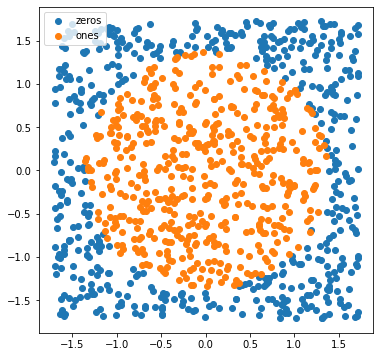

Training the model on 500 epochs with SGD optimizer and learning rate 5e-05
epoch 0, Loss 928325.0360268911
epoch 1, Loss 679.4298714150004
epoch 2, Loss 430.5830155594649
epoch 3, Loss 318.68460825149566
epoch 4, Loss 260.17669710996506
epoch 5, Loss 227.3437597725316
epoch 6, Loss 206.35956099211853
epoch 7, Loss 192.00313174763505
epoch 8, Loss 181.2350175790051
epoch 9, Loss 171.9270526691761
epoch 10, Loss 164.2243780290629
epoch 11, Loss 157.7499124297329
epoch 12, Loss 151.8977292175723
epoch 13, Loss 146.43644123893728
epoch 14, Loss 141.50112083492934
epoch 15, Loss 137.115934147188
epoch 16, Loss 133.06007129043206
epoch 17, Loss 129.25093710077408
epoch 18, Loss 125.80010773147083
epoch 19, Loss 122.82184522311651
epoch 20, Loss 120.14919825435979
epoch 21, Loss 117.6351929053537
epoch 22, Loss 115.32536184101889
epoch 23, Loss 113.26639075773292
epoch 24, Loss 111.32361871830597
epoch 25, Loss 109.5747556382508
epoch 26, Loss 107.98177596771961
epoch 27, Loss 106.5155979332

epoch 241, Loss 53.114080347377595
epoch 242, Loss 53.08354979359426
epoch 243, Loss 53.04851413336441
epoch 244, Loss 53.020946298846084
epoch 245, Loss 52.9876589797083
epoch 246, Loss 52.95613990294659
epoch 247, Loss 52.9275913589106
epoch 248, Loss 52.89887587990461
epoch 249, Loss 52.862834500130155
epoch 250, Loss 52.835354720655026
epoch 251, Loss 52.80748899281486
epoch 252, Loss 52.771087969594014
epoch 253, Loss 52.743666880332675
epoch 254, Loss 52.71267707957887
epoch 255, Loss 52.67894853955227
epoch 256, Loss 52.6483016151642
epoch 257, Loss 52.62274106384727
epoch 258, Loss 52.58705500295084
epoch 259, Loss 52.55841512453194
epoch 260, Loss 52.52453118117123
epoch 261, Loss 52.49519007405936
epoch 262, Loss 52.466701732303676
epoch 263, Loss 52.43370949155455
epoch 264, Loss 52.4073738349651
epoch 265, Loss 52.38264668419633
epoch 266, Loss 52.353348155947856
epoch 267, Loss 52.332117350547534
epoch 268, Loss 52.30015976596353
epoch 269, Loss 52.28030261848047
epoch 270

epoch 481, Loss 48.686155340961925
epoch 482, Loss 48.668134716935484
epoch 483, Loss 48.66991230112005
epoch 484, Loss 48.6548675570058
epoch 485, Loss 48.64168904040873
epoch 486, Loss 48.63231827477209
epoch 487, Loss 48.616922390965144
epoch 488, Loss 48.6038933724511
epoch 489, Loss 48.59334480208478
epoch 490, Loss 48.58194579084032
epoch 491, Loss 48.572106426494955
epoch 492, Loss 48.55364804800131
epoch 493, Loss 48.54279050832787
epoch 494, Loss 48.53427087898565
epoch 495, Loss 48.51677330008319
epoch 496, Loss 48.518989899418905
epoch 497, Loss 48.50401772801086
epoch 498, Loss 48.49380473499569
epoch 499, Loss 48.479911869767676
Performances using SGD optimizer
On train :


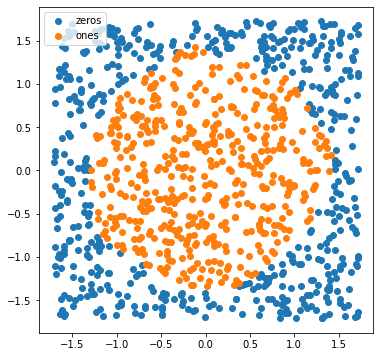

Accuracy is : 97.2%
Error rate : 2.799999999999997%
On test :


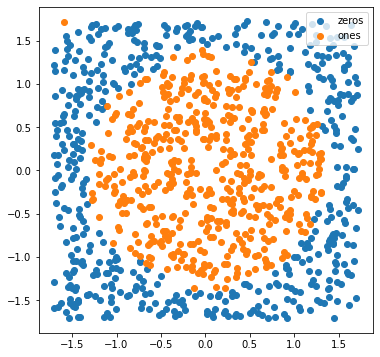

Accuracy is : 97.7%
Error rate : 2.299999999999997%


In [103]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)

model_sgd = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1)])

model_sgd = train_SGD(model_sgd, train_input, train_target, learning_rate=5e-5, nb_epochs=500, print_= True)

print("Performances using SGD optimizer")
print("On train :")
accuracy_and_plot_one_output(model_sgd, train_input, train_target)
print("On test :")
accuracy_and_plot_one_output(model_sgd, test_input, test_target)

Training the model on 500 epochs with sgd optimizer and learning rate 5e-05


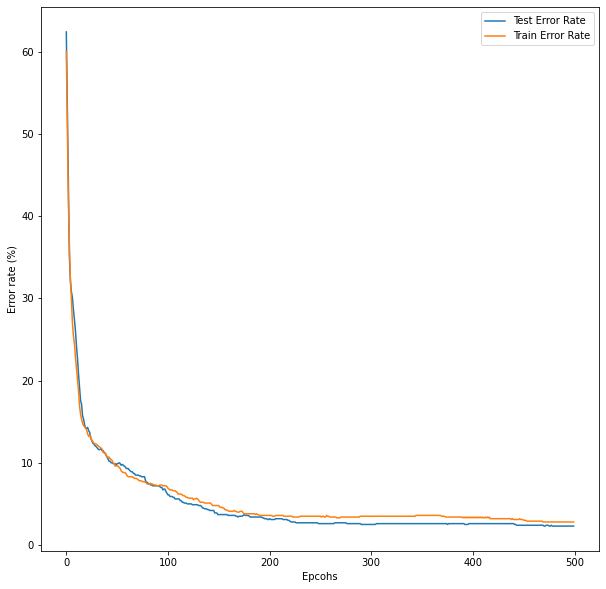

In [117]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)

model_sgd = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU() Linear(25, 1)])

train_and_plot_accuracy(model_sgd, train_input, train_target, test_input, test_target, optim="sgd", learning_rate=5e-5, nb_epochs=500, one_output=True, print_=False)
  

#### Using Adam

Training the model on 100 epochs with Adam optimizer and learning rate 0.005
epoch 0, Loss 81101.28697870669
epoch 1, Loss 15301.513311799237
epoch 2, Loss 9335.077490830026
epoch 3, Loss 17802.100591721784
epoch 4, Loss 1483.5977375521497
epoch 5, Loss 7043.961336758559
epoch 6, Loss 1297.2815308088793
epoch 7, Loss 2415.5801190024195
epoch 8, Loss 569.1274295289002
epoch 9, Loss 1107.6064612770485
epoch 10, Loss 539.0903008115232
epoch 11, Loss 447.6914583662251
epoch 12, Loss 473.09851464635204
epoch 13, Loss 220.28310174143473
epoch 14, Loss 222.45752778267263
epoch 15, Loss 206.98756727377872
epoch 16, Loss 163.85968246289343
epoch 17, Loss 149.63176366024663
epoch 18, Loss 146.65600056373046
epoch 19, Loss 129.30776298323485
epoch 20, Loss 102.44627938367404
epoch 21, Loss 92.017326508407
epoch 22, Loss 76.68004441363281
epoch 23, Loss 83.81748747801268
epoch 24, Loss 93.22152082727055
epoch 25, Loss 85.3757377975182
epoch 26, Loss 72.41921378404908
epoch 27, Loss 69.862167708294

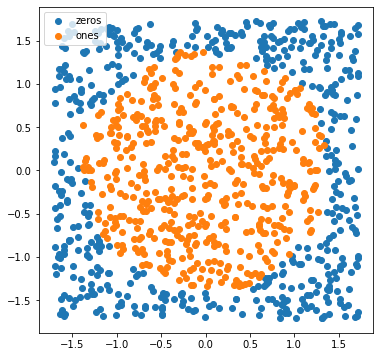

Accuracy is : 97.9%
Error rate : 2.0999999999999943%
On test :


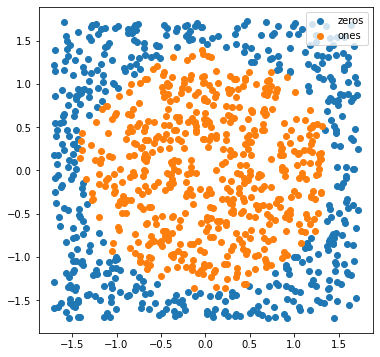

Accuracy is : 98.3%
Error rate : 1.7000000000000028%


In [110]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)

model_adam = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1)])

model_adam = train_adam(model_adam, train_input, train_target, learning_rate=0.005, nb_epochs=100, print_ = True)

print("Performances using Adam optimizer")
print("On train :")
accuracy_and_plot_one_output(model_adam, train_input, train_target)
print("On test :")
accuracy_and_plot_one_output(model_adam, test_input, test_target)

# Leftovers from  previous trials 

#### Our first model 
- Two inputs, Two output, 3 hidden layer ( one of 16 nodes and 2 of 32 ) 

This one performed pretty well also 

In [ ]:
def ye()

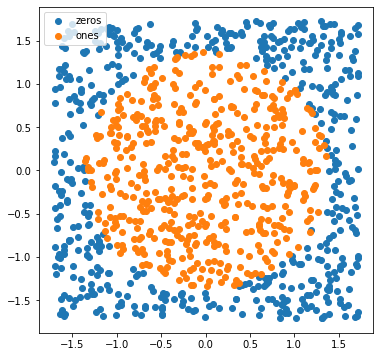

Training the model on 500 with SGD optimizer and learning rate 0.0001


In [23]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)

model_sgd = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

model_sgd = train_SGD(model_sgd, train_input, one_hot_targets, nb_epochs=200)

Performances using SGD optimizer
On train :


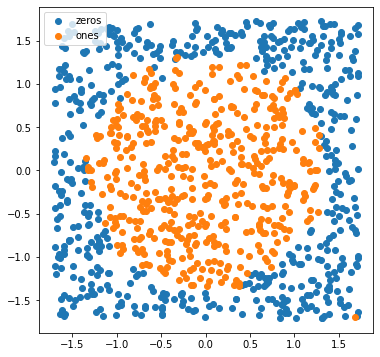

Accuracy is : 96.8%
Error rate : 3.200000000000003%
On test :


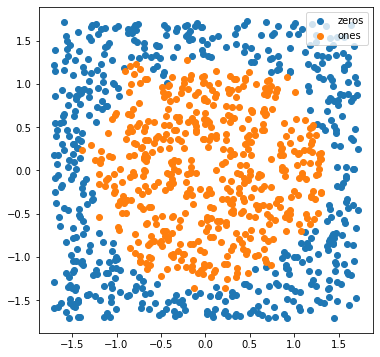

Accuracy is : 95.8%
Error rate : 4.200000000000003%


(95.8, 4.200000000000003)

In [27]:
print("Performances using SGD optimizer")
print("On train :")
accuracy_and_plot_two_output(model_sgd, train_input, train_target)
print("On test :")
accuracy_and_plot(model_sgd, test_input, test_target)

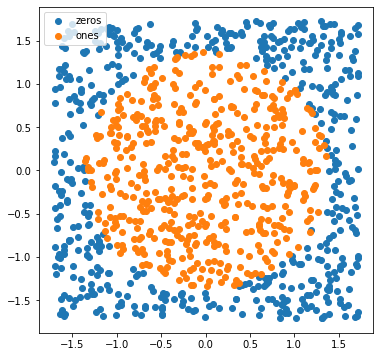

Training the model on 500 with Adam optimizer and learning rate 0.01


In [29]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)

model_adam = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

model_adam = train_adam(model_adam, train_input, one_hot_targets, learning_rate=0.01, nb_epochs=200)

Performances using Adam optimizer
On train :


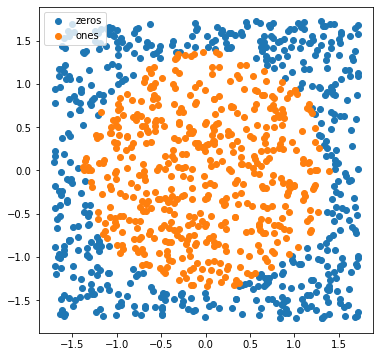

Accuracy is : 98.7%
Error rate : 1.2999999999999972%
On test :


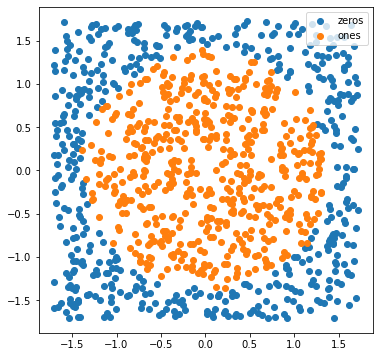

Accuracy is : 99.3%
Error rate : 0.7000000000000028%


(99.3, 0.7000000000000028)

In [30]:
print("Performances using Adam optimizer")
print("On train :")
accuracy_and_plot_two(model_adam, train_input, train_target)
print("On test :")
accuracy_and_plot(model_adam, test_input, test_target)

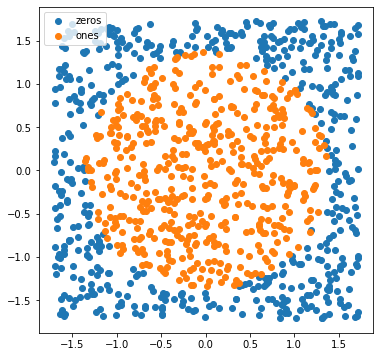

Training the model on 500 epochs with sgd optimizer and learning rate 0.0001


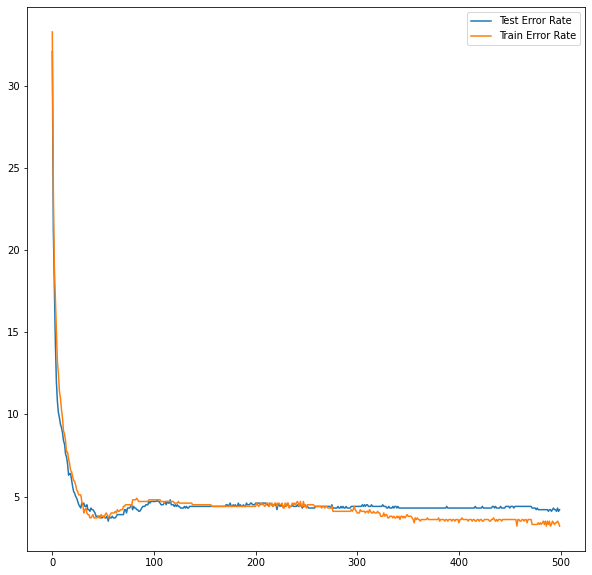

In [35]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

train_and_plot_accuracy(model, train_input, one_hot_targets, train_target, test_input, test_target, nb_epochs=200)
    

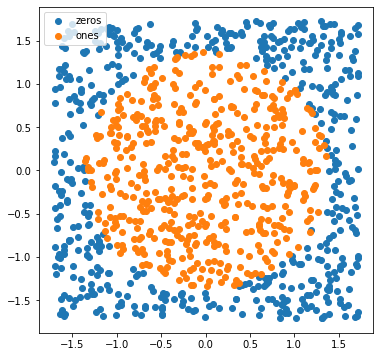

Training the model on 100 epochs with adam optimizer and learning rate 0.01


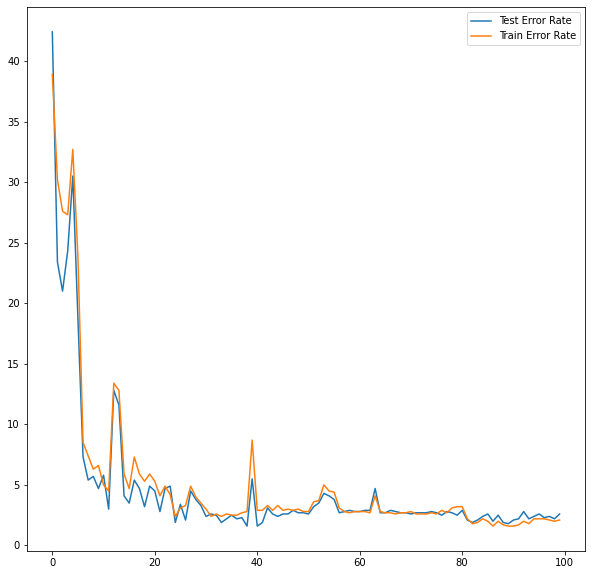

In [38]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

train_and_plot_accuracy(model, train_input, one_hot_targets, train_target, test_input, test_target, optim="adam", learning_rate=0.01, nb_epochs=100)
    